In [1]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch

from src.preprocessing.dataloader import Dataloader
from src.utils.features import generate_saliency_map,generate_grad_cam_map
from src.utils.mlflow import MLFlowRunManager

In [ ]:
mlflowhandler = MLFlowRunManager(run_id='c1172abbfc3b45469e0bb755b7cc4168')
model = mlflowhandler.manager.pytorch.load_model("mlflow-artifacts:/0/c1172abbfc3b45469e0bb755b7cc4168/artifacts/model" )
mlflowhandler.close()

In [4]:
dataloader = Dataloader(workers=12)
data = next(iter(dataloader.test_loader))

In [5]:
activation={}
def forward_hook1(module,input,output):
    activation['layer1_output'] = output
def forward_hook2(module,input,output):
    activation['layer2_output'] = output
def forward_hook3(module,input,output):
    activation['layer3_output'] = output
layer1 = model.layers['conv1']
layer2 = model.layers['conv2']
layer3 = model.layers['conv3']
hook1 = layer1.register_forward_hook(forward_hook1)
hook2 = layer2.register_forward_hook(forward_hook2)
hook3 = layer3.register_forward_hook(forward_hook3)


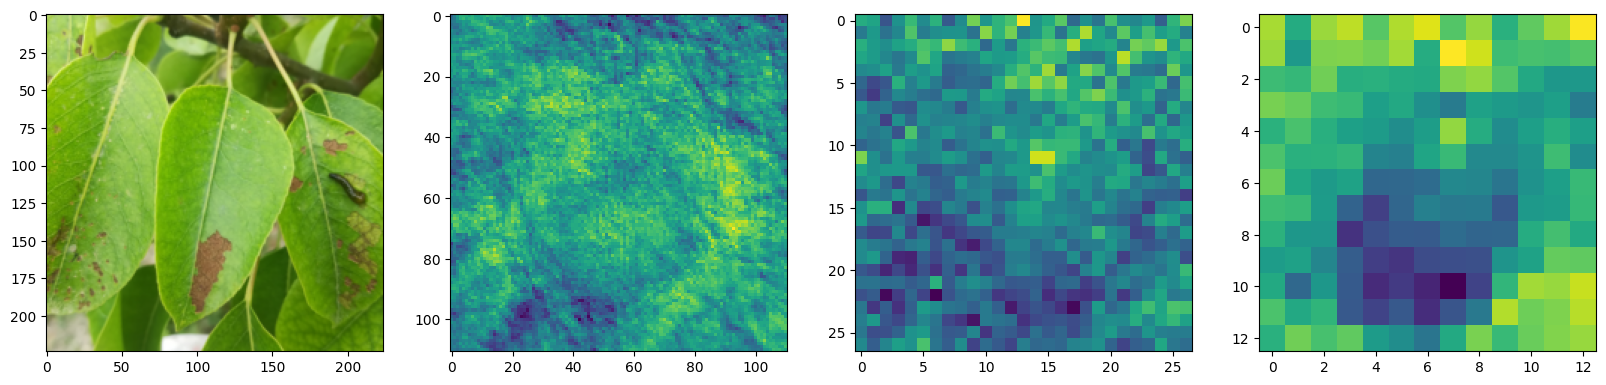

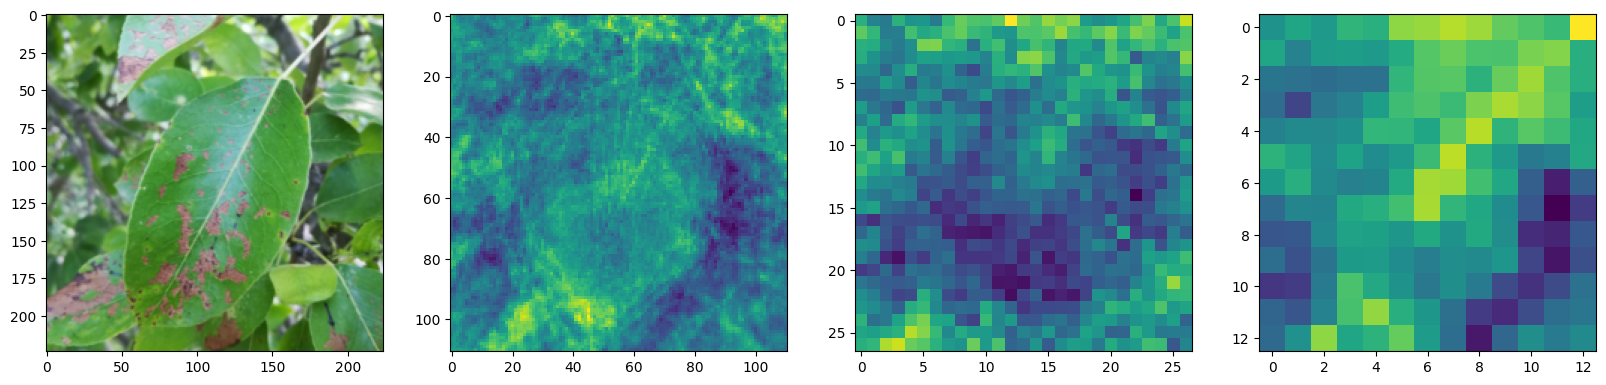

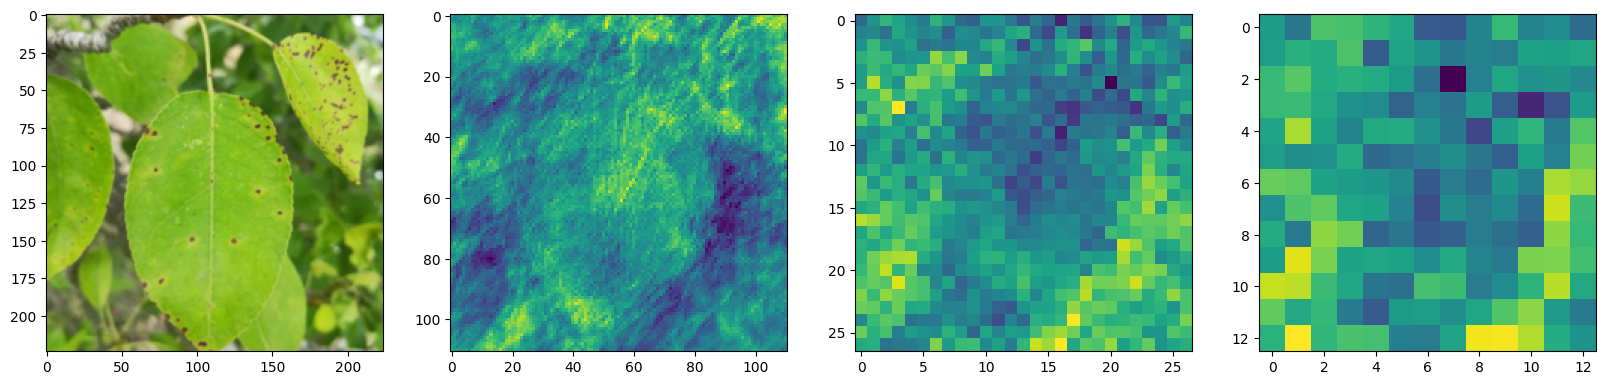

In [6]:
output = model(data[0])
activation_map1 = activation['layer1_output'].squeeze(0).mean(dim=0)
activation_map2 = activation['layer2_output'].squeeze(0).mean(dim=0)
activation_map3 = activation['layer3_output'].squeeze(0).mean(dim=0)

numbers = [np.random.randint(0,32) for i in range(3)]
for i in numbers:
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    ax[0].imshow(data[0][i].permute(1,2,0))
    ax[1].imshow(activation_map1[i].detach().numpy())
    ax[2].imshow(activation_map2[i].detach().numpy())
    ax[3].imshow(activation_map3[i].detach().numpy())
plt.show()

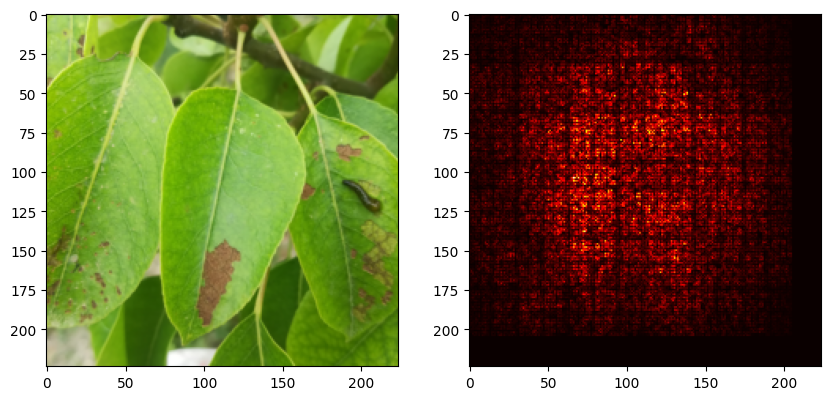

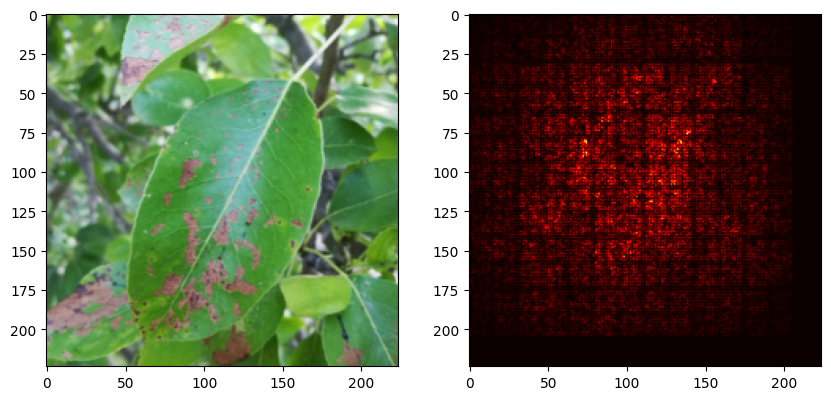

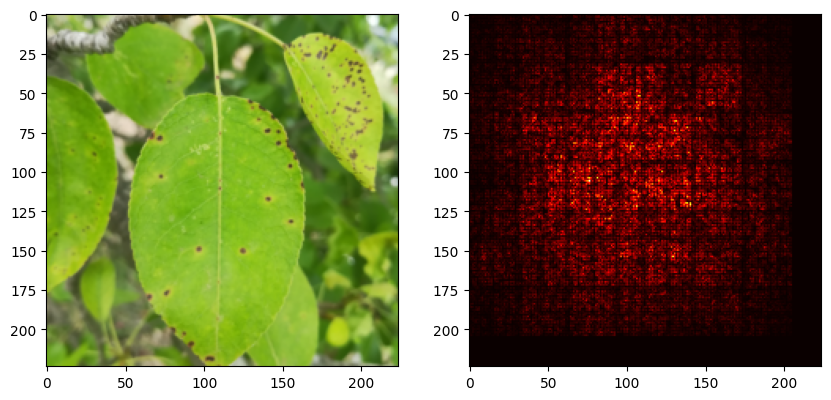

In [7]:
for i in numbers:
    generate_saliency_map(data,model,i)

/home/miza/.cache/pypoetry/virtualenvs/plant-disease-_5WkLGS_-py3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


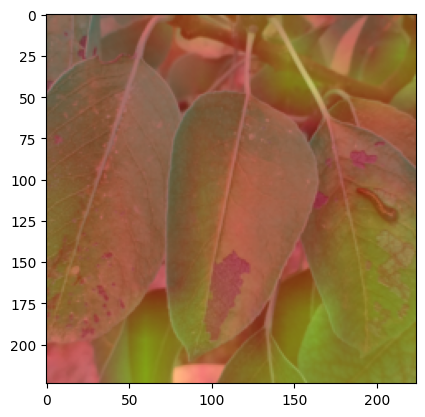

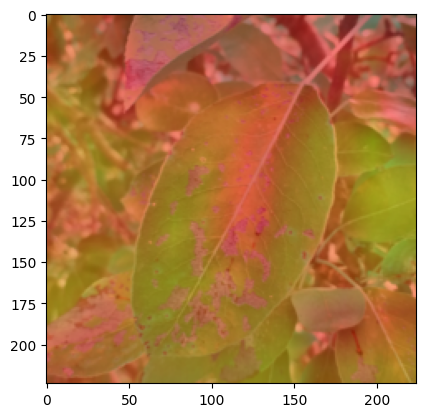

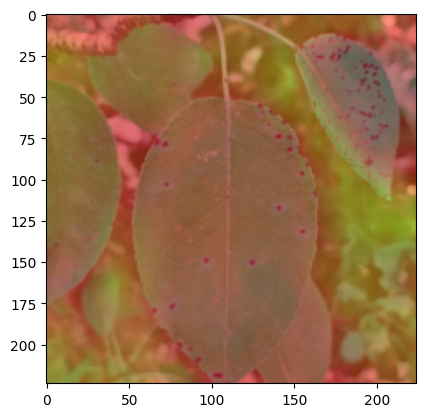

In [8]:
for i in numbers:
    generate_grad_cam_map(data,model,model.layers['conv3'],i,alpha=0.5)

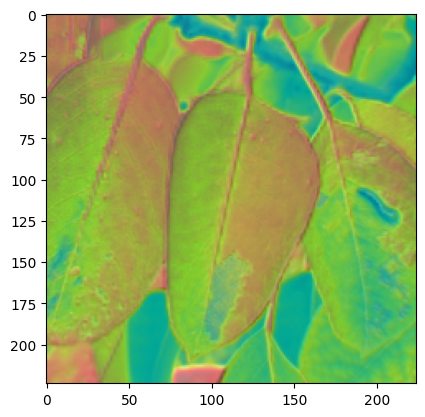

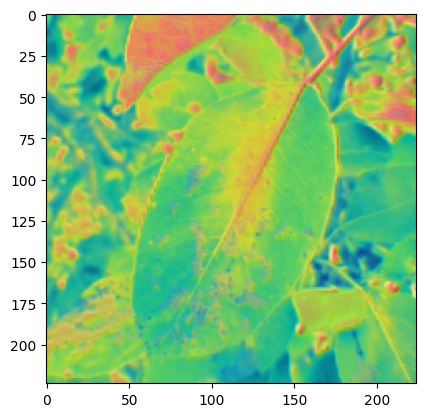

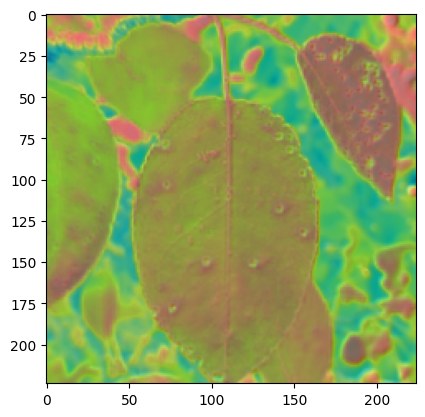

In [9]:
for i in numbers:
    generate_grad_cam_map(data,model,model.layers['conv1'],i,alpha=0.5)

In [ ]:
mlflowhandler = MLFlowRunManager(run_id='1b334c05f23d48e18e40653ae02319f5')
model_resnet = mlflowhandler.manager.pytorch.load_model("mlflow-artifacts:/0/1b334c05f23d48e18e40653ae02319f5/artifacts/model")
mlflowhandler.close()
model_resnet.eval()


In [29]:
activation={}
hook = model_resnet.layer1[0].register_forward_hook(forward_hook1)
hook2 = model_resnet.layer2[0].register_forward_hook(forward_hook2)
hook3 = model_resnet.layer3[0].register_forward_hook(forward_hook3)
output = model_resnet(data[0])

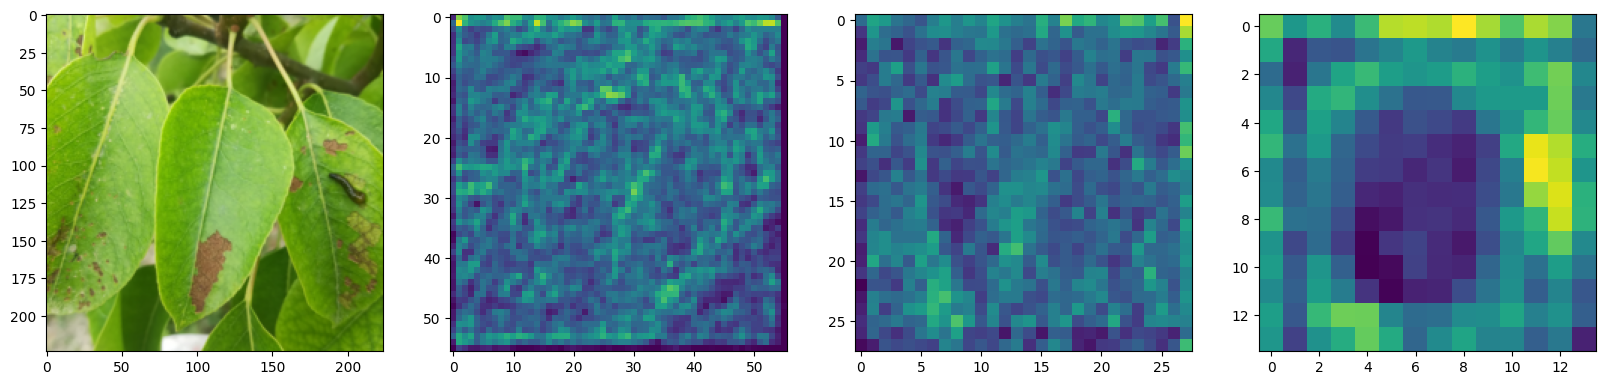

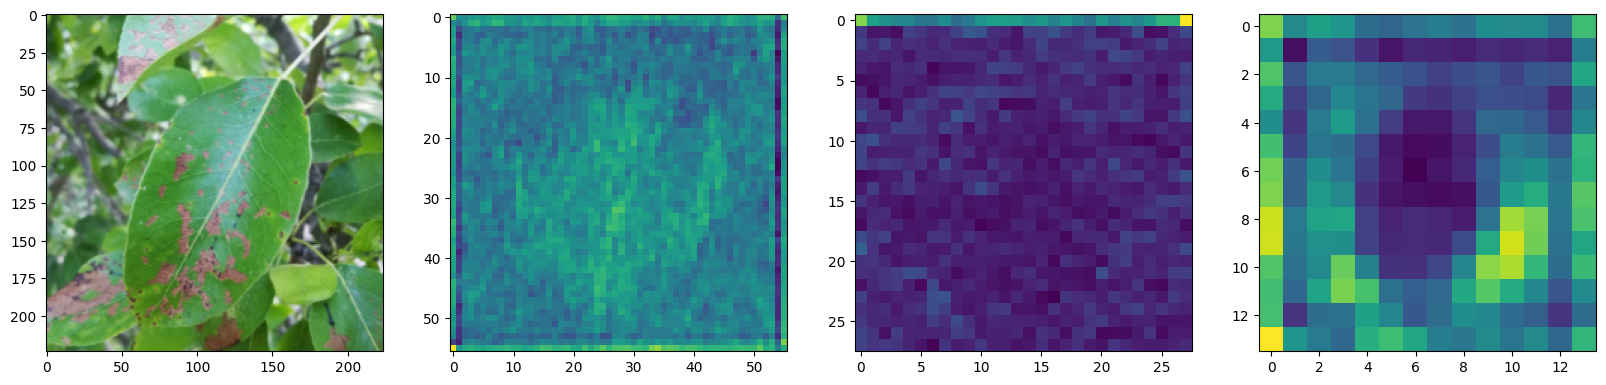

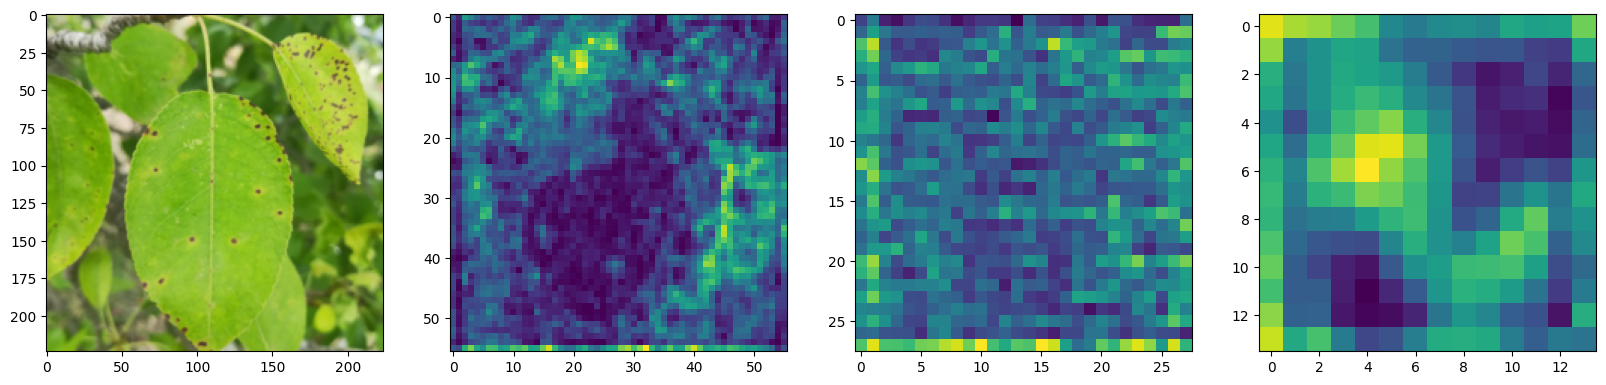

In [30]:
activation_map1 = activation['layer1_output'].squeeze(0).mean(dim=0)
activation_map2 = activation['layer2_output'].squeeze(0).mean(dim=0)
activation_map3 = activation['layer3_output'].squeeze(0).mean(dim=0)
for i in numbers:
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    ax[0].imshow(data[0][i].permute(1,2,0))
    ax[1].imshow(activation_map1[i].detach().numpy())
    ax[2].imshow(activation_map2[i].detach().numpy())
    ax[3].imshow(activation_map3[i].detach().numpy())
plt.show()

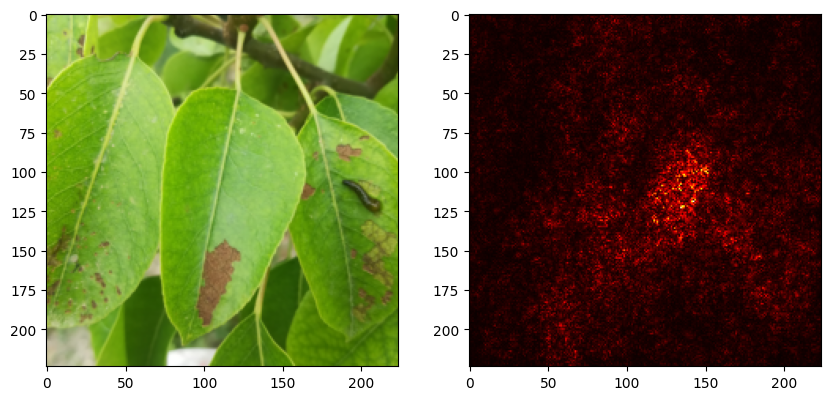

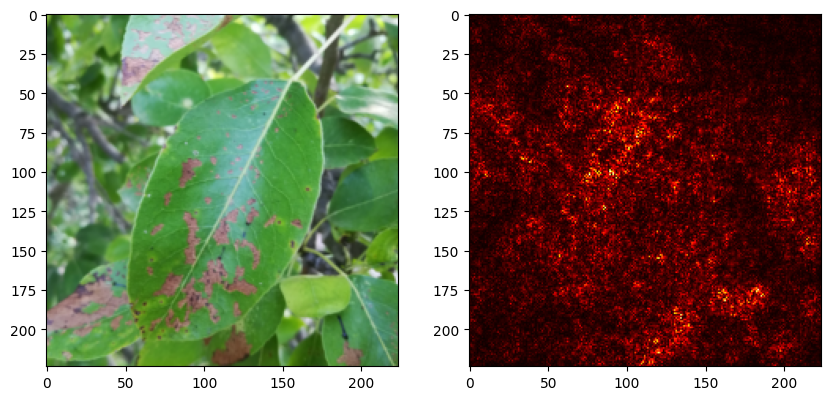

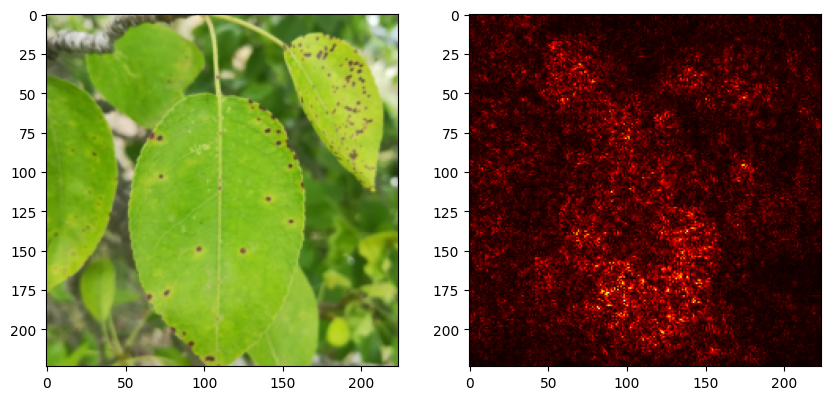

In [14]:
for i in numbers:
    generate_saliency_map(data,model_resnet,i)

/home/miza/.cache/pypoetry/virtualenvs/plant-disease-_5WkLGS_-py3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


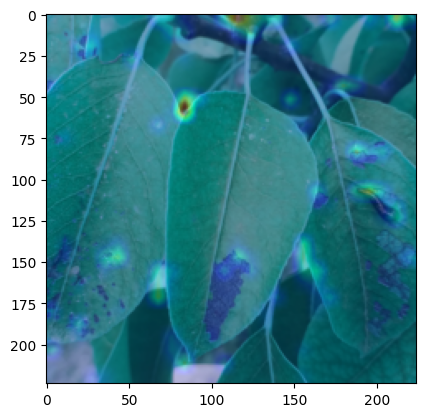

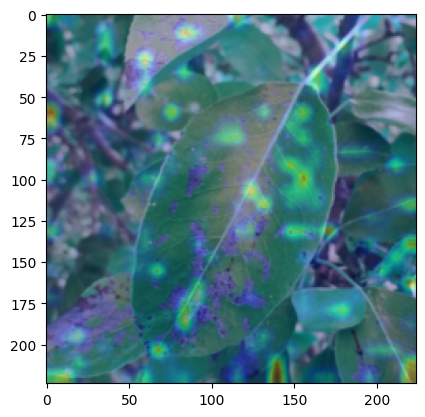

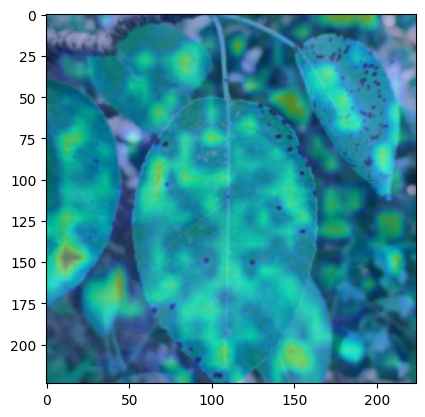

In [38]:
for param in model_resnet.layer2.parameters():
    param.requires_grad = True
for i in numbers:
    generate_grad_cam_map(data,model_resnet,model_resnet.layer2,i)

/home/miza/.cache/pypoetry/virtualenvs/plant-disease-_5WkLGS_-py3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


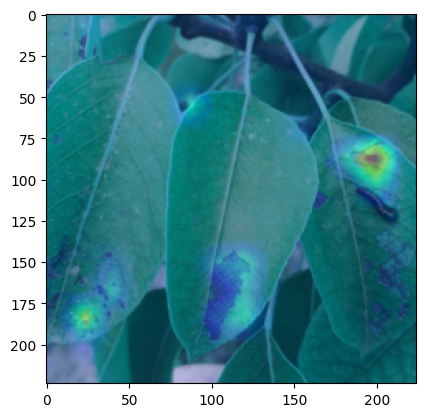

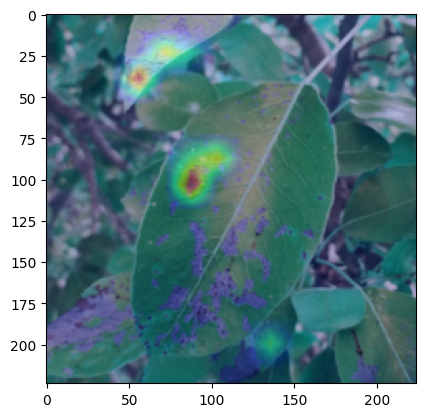

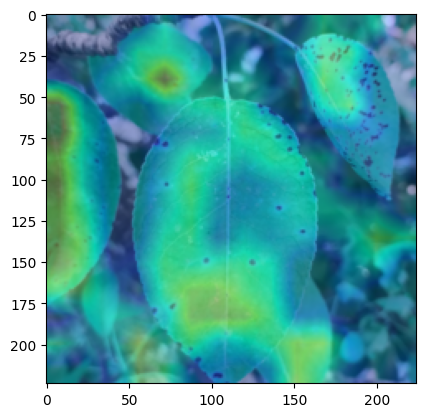

In [16]:
for i in numbers:
    generate_grad_cam_map(data,model_resnet,model_resnet.layer3,i)

The analysis of activation, saliency and gradcam from both of the models strongly suggest that resnet is way better in extracting correct features from images. A small and own implementation of CNN model is certainly not complex enough to extract features. It does not focus on correct parts of the image to draw out conclusions about classification and the whole accuracy bases mostly on class imbalance